In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
from metpy.plots import SkewT
from metpy.units import pandas_dataframe_to_unit_arrays, units
import numpy as np
from siphon.simplewebservice.wyoming import WyomingUpperAir
import metpy.calc as mpcalc

import matplotlib.patches as mpatches

In [2]:
# download data
# http://
from getmac import get_mac_address as gma
print(gma())
# save mac address to a mac;
mac = gma()

dt = datetime(2021, 9, 23, 0)
adt = dt.strftime("%Y%m%d%H%M%S")

# 45004 Kings Park HONG KONG
# 48900 胡志明市

station = '91212'
# station = '48900'

if station == '91212':
    astn = 'Guam'

# if station == '48900':
#     astn = 'hcm'

#read sounding data
data = WyomingUpperAir.request_data(dt, station)

# create a dictionary with metpy
df = pandas_dataframe_to_unit_arrays(data)
print(df.keys())

3c:a6:f6:22:6e:17
dict_keys(['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed', 'u_wind', 'v_wind', 'station', 'station_number', 'time', 'latitude', 'longitude', 'elevation', 'pw'])


In [3]:
# extract data
p = df['pressure']
#print (p)
T = df['temperature']
Td = df['dewpoint']
u = df['u_wind']
v = df['v_wind']

cape = 307.9214412766162 joule / kilogram, cin = -371.4182379247759 joule / kilogram
lcl_pressure = 991.7252068669433 hectopascal
lfc_pressure = 569.9134267731889 hectopascal


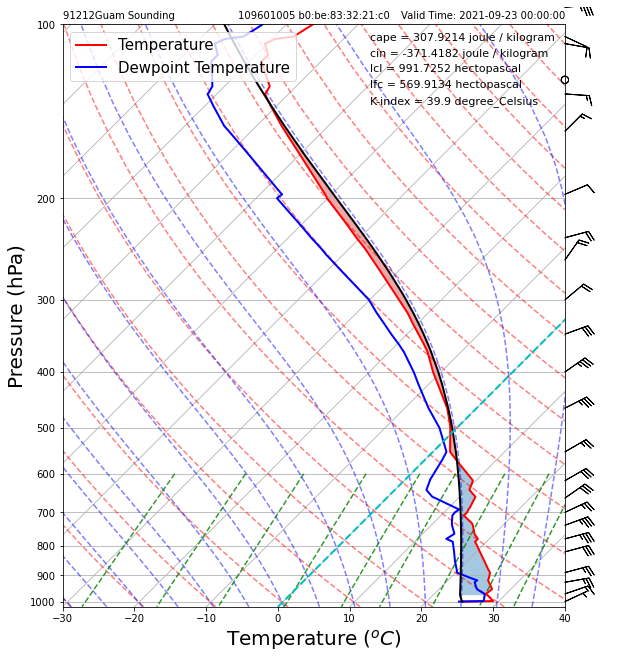

In [10]:
# plotting
fig = plt.figure(figsize=(9,11))
skew = SkewT(fig, rotation=45)

skew.plot(p, T, 'r', lw=2, label='Temperature')
skew.plot(p, Td, 'b', lw=2, label='Dewpoint Temperature')
skew.plot_barbs(p[::3], u[::3], v[::3], y_clip_radius=0.03)

skew.ax.set_xlim(-30,40)
skew.ax.set_ylim(1020,100)


# alpha= transparency
skew.plot_dry_adiabats(t0=np.arange(233, 533, 10)*units.K, alpha=0.5, color='orange')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5)*units.K, alpha=0.5, color='green')
skew.plot_mixing_lines()


#Calculate full parcel profile
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth = 2)


# calculate Convective Available Potential Energy: CAPE;
# 对流有效位能（CAPE）：正不稳定能量，是气块达到自由对流高度后可以获得继续上升的能量

# calculate Convective INhibition: CIN
# 对流抑制能量（CIN）：负不稳定能量，是大气底层的气块要能达到自由对流高度
cape, cin = mpcalc.cape_cin(p, T, Td, prof, which_lfc = 'bottom', which_el = 'top')
print (f'cape = {cape}, cin = {cin}')


#
skew.shade_cin(p, T, prof, Td)
skew.shade_cape(p, T, prof)


# Lifted Condensation Level; LCL;
# Level of Free Convection; LFC;
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
print (f'lcl_pressure = {lcl_pressure}')

lfc_pressure, lfc_temperature = mpcalc.lfc(p, T, Td, parcel_temperature_profile = prof)
print (f'lfc_pressure = {lfc_pressure}')


# K-index
cape, cin = mpcalc.cape_cin(p, T, Td, prof) 
K = mpcalc.k_index(p, T, Td)
# print (K)


#
plt.title('109601005 ' + "b0:be:83:32:21:c0", fontsize = 10, loc = 'center')
# plt.title('109601004 ' + mac, fontsize = 10, loc = 'center')

plt.title('{} Sounding'.format(station + astn), fontsize=10, loc='left')
plt.title('Valid Time: {}'.format(dt), fontsize=10, loc='right')
plt.xlabel("Temperature ($^oC$)", fontsize=20)
plt.ylabel("Pressure (hPa)", fontsize=20)

plt.legend(loc='upper left', fontsize=15)


#
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)


# plt.Legend(['T cape = {:.7}'.format(cape), 'Td cin = {:.7}'.format(cin)])
# fig.text(0.60, 0.85, 'cape = {:.7}'.format(cape), fontsize = 11)
# fig.text(0.60, 0.83, 'cin = {:.7}'.format(cin), fontsize = 11)
# fig.text(0.60, 0.81, 'lcl = {:.7}'.format(lcl_pressure), fontsize = 11)
# fig.text(0.60, 0.79, 'lfc = {:.7}'.format(lfc_pressure), fontsize = 11)
# fig.text(0.60, 0.77, 'K-index = {:.7}'.format(K), fontsize = 11)

fig.text(0.60, 0.85, 'cape = {:.7}'.format(cape), fontsize = 11)
fig.text(0.60, 0.83, 'cin = {:.7}'.format(cin), fontsize = 11)
fig.text(0.60, 0.81, 'lcl = {:.7}'.format(lcl_pressure), fontsize = 11)
fig.text(0.60, 0.79, 'lfc = {:.7}'.format(lfc_pressure), fontsize = 11)

fig.text(0.60, 0.77, 'K-index = {:.7}'.format(K), fontsize = 11)

plt.show()

fig.savefig('ttskewt_{}.png'.format(astn + adt), dpi = 300)